# HW6 - Continuous environment / algorithm
# Arian Mohammadkhani 810603136

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym
import time
from tabulate import tabulate

In [2]:
class ContinuousMountainCar:
    def __init__(self):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.max_steps = 200
        self.reset()

    def reset(self):
        self.position = np.random.uniform(-0.6, -0.4)
        self.velocity = 0.0
        self.steps = 0
        return np.array([self.position, self.velocity])

    def step(self, force):
        force = np.clip(force, -1, 1)
        self.velocity += force * 0.0015 - 0.0025 * np.cos(3 * self.position)
        self.velocity = np.clip(self.velocity, -self.max_speed, self.max_speed)
        self.position += self.velocity
        if self.position < self.min_position:
            self.position = self.min_position
            self.velocity = 0.0
        if self.position > self.max_position:
            self.position = self.max_position
            self.velocity = 0.0

        done = False
        reward = -1  
        self.steps += 1
        if self.position >= self.goal_position or self.steps >= 200:
            done = True
            reward = 100
        return np.array([self.position, self.velocity]), reward, done

In [3]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64

        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_model()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor(np.vstack([x[0] for x in minibatch]))
        actions = torch.LongTensor([x[1] for x in minibatch])
        rewards = torch.FloatTensor([x[2] for x in minibatch])
        next_states = torch.FloatTensor(np.vstack([x[3] for x in minibatch]))
        dones = torch.FloatTensor([x[4] for x in minibatch])

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q = self.target_model(next_states).max(1)[0].detach()
        target = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(current_q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [4]:
def train_dqn_continuous():
    env = ContinuousMountainCar()
    state_size = 2
    action_size = 10
    agent = DQNAgent(state_size, action_size)

    episodes = 1000
    rewards = []
    start_time = time.time()

    for e in range(episodes):
        state = env.reset().reshape(1, -1)
        total_reward = 0
        done = False

        while not done:
            action_idx = agent.act(state)
            action = np.linspace(-1, 1, action_size)[action_idx]
            next_state, reward, done = env.step(action)
            next_state = next_state.reshape(1, -1)

            agent.remember(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward

            agent.replay()

        agent.update_target_model()
        rewards.append(total_reward)

        if (e + 1) % 100 == 0:
            print(f"Episode {e + 1}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds")

    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg)
    plt.title("Continuous DQN - Moving Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

    return agent, rewards

Episode 100, Reward: 20, Epsilon: 0.01
Episode 200, Reward: 18, Epsilon: 0.01
Episode 300, Reward: 27, Epsilon: 0.01
Episode 400, Reward: 33, Epsilon: 0.01
Episode 500, Reward: 28, Epsilon: 0.01
Episode 600, Reward: 33, Epsilon: 0.01
Episode 700, Reward: 27, Epsilon: 0.01
Episode 800, Reward: 34, Epsilon: 0.01
Episode 900, Reward: 33, Epsilon: 0.01
Episode 1000, Reward: 31, Epsilon: 0.01
Training finished in 105.57 seconds


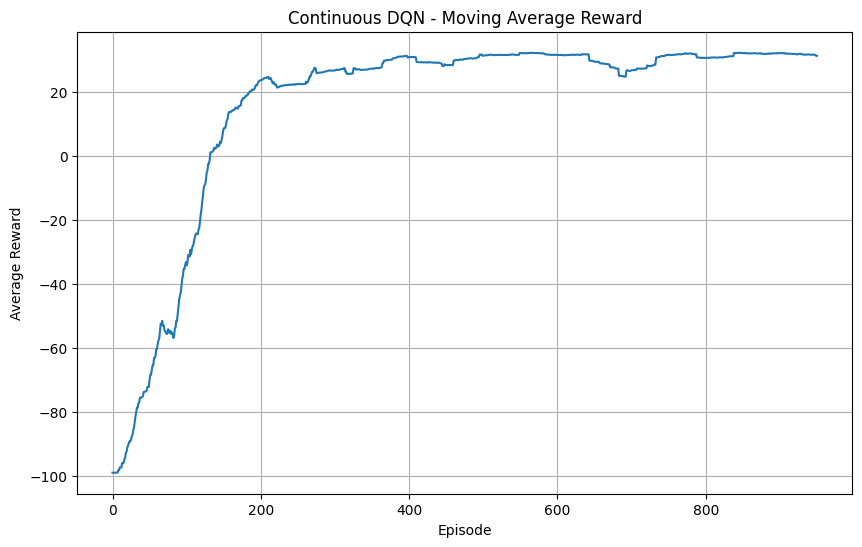

In [5]:
start_time = time.time()
agent_continuous, reward_continuous = train_dqn_continuous()
dqn_time = time.time() - start_time

In [6]:
def evaluate_dqn_gym(actor):
    env = gym.make("MountainCar-v0", render_mode="human")
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = actor.model(state_tensor)
            action_idx = torch.argmax(q_values).item()

        if action_idx <= 1:
            discrete_action = 0  # push left
        elif action_idx == 2:
            discrete_action = 1  # no push
        else:
            discrete_action = 2  # push right

        state, reward, done, truncated, info = env.step(discrete_action)
        total_reward += reward
        time.sleep(0.01)

    print(f"\nTotal Reward in Gym Environment: {total_reward}")
    env.close()
    
evaluate_dqn_gym(agent_continuous)


Total Reward in Gym Environment: -204.0


## DDPG Implementation for Continuous MountainCar

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        return x * self.max_action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x



class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.array(state), np.array(action), np.array(reward), 
                np.array(next_state), np.array(done))

    def __len__(self):
        return len(self.buffer)


class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0005)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)

        self.replay_buffer = ReplayBuffer(100000)
        self.max_action = max_action
        self.gamma = 0.99
        self.tau = 0.005

    def select_action(self, state, noise=0.0):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().cpu().numpy()[0]
        action += noise
        return np.clip(action, -self.max_action, self.max_action)

    def train(self, batch_size=128):
        if len(self.replay_buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(np.float32(dones)).unsqueeze(1)

        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            target_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards + (1 - dones) * self.gamma * target_Q
        current_Q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


def train_ddpg(agent, env, n_episodes=1000, max_steps=200, window_size=100, noise_generator=None, plot=True):
    reward_history = []
    avg_reward_history = []

    for episode in range(n_episodes):
        state = env.reset()
        if noise_generator:
            noise_generator.reset()

        episode_reward = 0
        for step in range(max_steps):
            noise = noise_generator.noise() if noise_generator else 0
            action = agent.select_action(state, noise=noise)
            action_to_env = float(action)

            next_state, reward, done = env.step(action_to_env)

            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train()

            state = next_state
            episode_reward += reward

            if done:
                break

        reward_history.append(episode_reward)

        if (episode + 1) % window_size == 0:
            avg_reward = np.mean(reward_history[-window_size:])
            avg_reward_history.append(avg_reward)
            print(f"Episode {episode+1}, Average Reward (last {window_size}): {avg_reward}")

    if plot:
        plt.plot(range(window_size, n_episodes + 1, window_size), avg_reward_history)
        plt.xlabel('Episode')
        plt.ylabel(f'Average Reward (per {window_size} episodes)')
        plt.title('DDPG on Continuous MountainCar')
        plt.grid()
        plt.show()

    return reward_history, avg_reward_history

C:\Users\arian\AppData\Local\Temp\ipykernel_24676\1034345589.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action_to_env = float(action)


Episode 50, Average Reward (last 50): -99.0
Episode 100, Average Reward (last 50): -53.9
Episode 150, Average Reward (last 50): 10.98
Episode 200, Average Reward (last 50): 12.38
Episode 250, Average Reward (last 50): 22.44
Episode 300, Average Reward (last 50): 11.2
Episode 350, Average Reward (last 50): 0.46
Episode 400, Average Reward (last 50): 16.62
Episode 450, Average Reward (last 50): 16.8
Episode 500, Average Reward (last 50): 15.02
Episode 550, Average Reward (last 50): 22.98
Episode 600, Average Reward (last 50): 20.42
Episode 650, Average Reward (last 50): 15.74
Episode 700, Average Reward (last 50): 15.72
Episode 750, Average Reward (last 50): 17.24
Episode 800, Average Reward (last 50): 15.04
Episode 850, Average Reward (last 50): 10.42
Episode 900, Average Reward (last 50): 20.84
Episode 950, Average Reward (last 50): 11.72
Episode 1000, Average Reward (last 50): 14.42


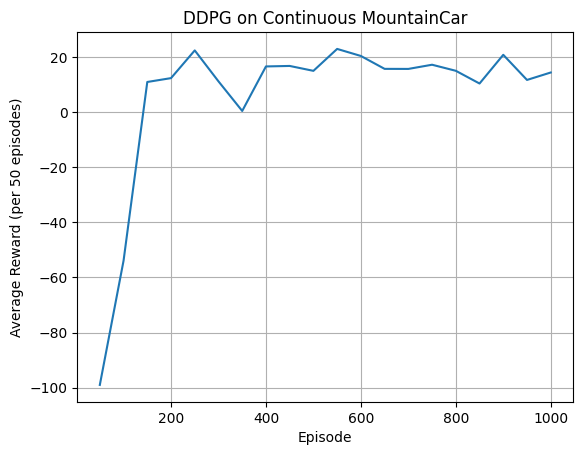

⏱ DDPG Training Time: 376.66 seconds


In [8]:
env = ContinuousMountainCar()
state_dim = 2
action_dim = 1
max_action = 1

agent = DDPGAgent(state_dim, action_dim, max_action)
ou_noise = OUNoise(action_dim)

start_time = time.time()
reward_history, avg_reward_history = train_ddpg(
    agent, env, n_episodes=1000, max_steps=200, window_size=50, noise_generator=ou_noise
)
end_time = time.time()
ddpg_time = time.time() - start_time
print(f"⏱ DDPG Training Time: {end_time - start_time:.2f} seconds")

In [9]:
def evaluate_ddpg_continuous(actor, env_name="MountainCarContinuous-v0", device="cpu"):
    env = gym.make(env_name, render_mode="human")  
    state, _ = env.reset()
    total_reward = 0
    done = False
    truncated = False

    while not (done or truncated):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = actor(state_tensor).cpu().numpy().flatten()
            action = np.clip(action, -1, 1)  

        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        time.sleep(0.01)  

    print(f"\n Total Reward: {total_reward}")
    env.close()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent.actor.to(device)

evaluate_ddpg_continuous(agent.actor, "MountainCarContinuous-v0", device)


 Total Reward: 93.5105588011569


In [10]:
def evaluate_agent(agent, env, is_dqn=True, num_episodes=10, device='cpu'):

    steps_list = []
    success_count = 0

    for _ in range(num_episodes):
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        done = False
        steps = 0

        while not done:
            if is_dqn:
                state_input = np.reshape(state, [1, -1])
                action_idx = agent.act(state_input)
                action = float(np.linspace(-1, 1, 10)[action_idx])
            else:

                state_tensor = torch.FloatTensor(state).reshape(1, -1).to(device)
                with torch.no_grad():
                    action = agent(state_tensor).cpu().numpy().flatten()
                    action = np.clip(action, -1, 1)
                action = float(action[0]) if action.shape[0] == 1 else action

            step_result = env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done = step_result

            state = next_state
            steps += 1


            if steps >= getattr(env, "max_steps", 200):
                break

        steps_list.append(steps)


        if steps < getattr(env, "max_steps", 200):
            success_count += 1

    return {
        'avg_steps': np.mean(steps_list),
        'success_rate': success_count / num_episodes,
        'steps_history': steps_list
    }

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_eval = ContinuousMountainCar()

results_dqn = evaluate_agent(agent_continuous, env_eval, is_dqn=True, device=device)
results_ddpg = evaluate_agent(agent.actor, env_eval, is_dqn=False, device=device)

table = [
    ["Model", "Avg Steps", "Success Rate", "Training Time (s)"],
    ["DQN", f"{results_dqn['avg_steps']:.1f}", f"{results_dqn['success_rate']:.2f}", f"{dqn_time:.1f}"],
    ["DDPG", f"{results_ddpg['avg_steps']:.1f}", f"{results_ddpg['success_rate']:.2f}", f"{ddpg_time:.1f}"]
]
print("\nPerformance Comparison:")
print(tabulate(table, headers="firstrow", tablefmt="grid"))


Performance Comparison:
+---------+-------------+----------------+---------------------+
| Model   |   Avg Steps |   Success Rate |   Training Time (s) |
+=========+=============+================+=====================+
| DQN     |        73.4 |              1 |               106.5 |
+---------+-------------+----------------+---------------------+
| DDPG    |        68.1 |              1 |               376.7 |
+---------+-------------+----------------+---------------------+


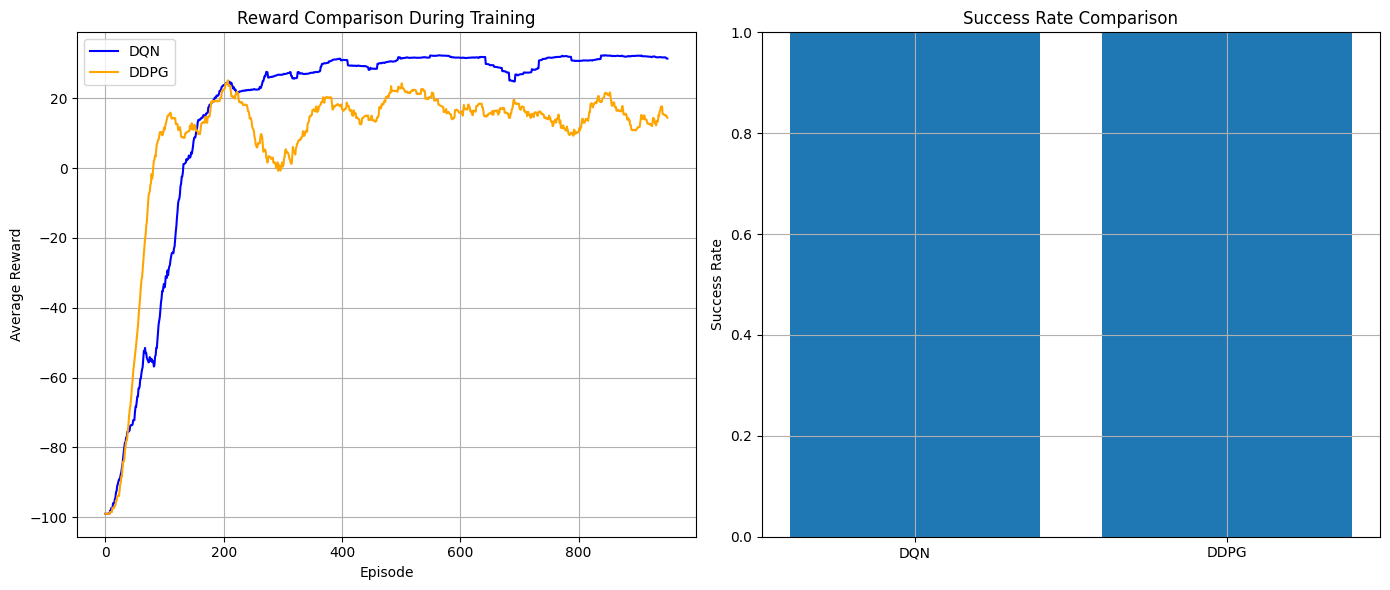

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
window_size = 50
moving_avg_dqn = np.convolve(reward_continuous, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_dqn, label='DQN', color='blue')

moving_avg_ddpg = np.convolve(reward_history, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg_ddpg, label='DDPG', color='orange')

plt.title("Reward Comparison During Training")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(['DQN', 'DDPG'], [results_dqn['success_rate'], results_ddpg['success_rate']])
plt.title("Success Rate Comparison")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

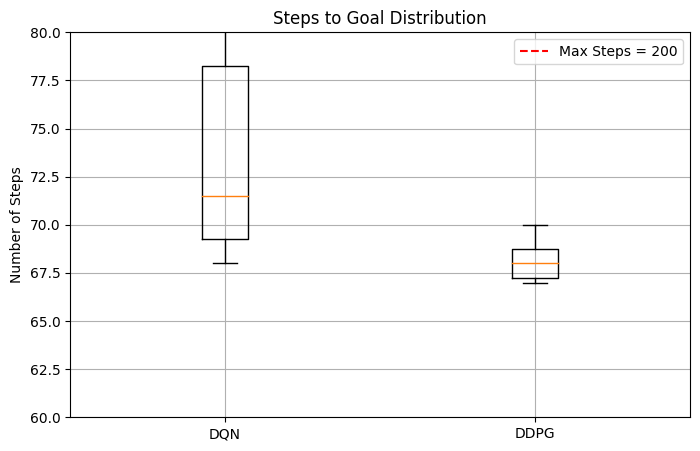

In [13]:
plt.figure(figsize=(8, 5))
plt.boxplot([results_dqn['steps_history'], results_ddpg['steps_history']],
            labels=['DQN', 'DDPG'])
plt.title("Steps to Goal Distribution")
plt.ylabel("Number of Steps")
plt.axhline(getattr(env_eval, "max_steps", 200), color='r', linestyle='--', label='Max Steps = 200')
plt.legend()
plt.ylim(60, 80)
plt.grid(True)
plt.show()